In [ ]:
# =========================
# 0) 의존성 & 기본 폴더
# =========================
# [R4] 센서/EMA 이상치에 강건해지기 위해 robust z-score 및 분위수 클리핑 사용(완전 동일 알고리즘은 아님).

!pip -q install pyyaml

import os, glob, math, zipfile
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files

BASE = "/content"
os.makedirs(f"{BASE}/data/raw", exist_ok=True)
os.makedirs(f"{BASE}/data/extracted", exist_ok=True)
os.makedirs(f"{BASE}/work", exist_ok=True)

# ---- 모드 스위치 / 분석 대상 ----
MODE = "both"        # "env_only" | "bio_only" | "both"
TARGET_ID = None     # 특정 참가자만 분석하고 싶으면 ID 지정, None이면 자동 선택

In [ ]:
# =========================
# 1) 데이터 업로드 & 압축 해제
# =========================
print("TS_A_01/02/06 ZIP 파일을 업로드하세요 (여러 개 선택 가능)")
uploaded = files.upload()

for name in uploaded:
    os.replace(name, f"{BASE}/data/raw/{name}")

for z in glob.glob(f"{BASE}/data/raw/*.zip"):
    print("extract:", os.path.basename(z))
    with zipfile.ZipFile(z) as zz:
        zz.extractall(f"{BASE}/data/extracted")
print("done.")


TS_A_01/02/06 ZIP 파일을 업로드하세요 (여러 개 선택 가능)


Saving TS_A.신규수집_01.환경측정.zip to TS_A.신규수집_01.환경측정.zip
Saving TS_A.신규수집_02.생체신호.zip to TS_A.신규수집_02.생체신호.zip
extract: TS_A.신규수집_02.생체신호.zip
extract: TS_A.신규수집_01.환경측정.zip
done.


In [ ]:
# =========================
# 2) 원천 → 10분 격자 특징 + EI
# =========================
# [R1] MRT/JITAI 맥락의 '근접(proximal) 지표'로 EI를 구성하고,
# 날짜별 분위수(Q=0.80)를 '그날의 안전 평형 경계(thr)'로 사용.
# [R6] ERT/ACI로 '위험 체류시간/면적'을 최소화하는 것이
# time-to-injury 지연과 같은 방향의 목적임을 가정.

RAW = "/content/data/extracted"
OUT = "/content/work/features_ei.csv"

SYN = {
  "time":  ["Time","time","timestamp","Timestamp","측정시각","일시","datetime","DateTime","date","Date","기록일시"],
  "temp":  ["temp","temperature","온도","Temp","Temperature"],
  "rh":    ["rh","humidity","습도","RH","Humidity"],
  "co2":   ["co2","이산화탄소","CO2","co₂"],
  "tvoc":  ["tvoc","TVOC","휘발성","총휘발성유기화합물","VOC","voc"],
  "hr":    ["hr","HR","bpm","BPM","heart_rate","HeartRate","심박","심박수","pulse"],
  "br":    ["br","resp","resp_rate","호흡","호흡수"],
  "skin_t":["skin_t","skin_temp","skin temperature","피부온","피부온도"],
  "stress":["stress","스트레스","피로","피로도","strain","stress_index","스트레스지수"],
  "act":   ["act","activity","Activity","Activity_IR","활동","활동량","ACC","acc","activity_index","활동강도"],
  "steps": ["steps","step","걸음","걸음수","Steps"],
  "id":    ["id","ID","pid","participant","subject","대상자ID","피험자ID","user_id","UID"],
}

def find_col(df, keys):
    cols = list(df.columns)
    lower = {c.lower(): c for c in cols}
    for k in keys:
        if k in df.columns: return k
        if k.lower() in lower: return lower[k.lower()]
    return None

def read_any(path, nrows=None):
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xlsx",".xls"]:
        try: return pd.read_excel(path, nrows=nrows)
        except: return None
    for enc in ["utf-8-sig","cp949","utf-8"]:
        try: return pd.read_csv(path, encoding=enc, nrows=nrows)
        except: continue
    return None

def robust_z(s):
    s = pd.to_numeric(s, errors="coerce").astype(float)
    med = np.nanmedian(s); iqr = np.nanpercentile(s,75)-np.nanpercentile(s,25)
    if not iqr or math.isnan(iqr): iqr = 1.0
    return (s - med)/iqr

sigmoid = lambda x: 1/(1+np.exp(-x))

env_ls, bio_ls = [], []
for path in glob.glob(f"{RAW}/**/*.*", recursive=True):
    if os.path.splitext(path)[1].lower() not in [".csv",".xlsx",".xls",".txt"]:
        continue
    df = read_any(path)
    if df is None or df.empty: continue

    tcol = find_col(df, SYN["time"]) or df.columns[0]
    df = df.rename(columns={tcol:"Time"})
    try:
        df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
    except Exception:
        continue
    df = df.dropna(subset=["Time"]).copy()
    if df.empty: continue

    has_env = all(find_col(df, SYN[k]) for k in ["temp","rh","co2","tvoc"])
    has_bio = any(find_col(df, SYN[k]) for k in ["hr","steps","act","stress","br","skin_t"])
    idcol   = find_col(df, SYN["id"])

    if has_env and MODE in ["both","env_only"]:
        keep = ["Time", find_col(df,SYN["temp"]), find_col(df,SYN["rh"]), find_col(df,SYN["co2"]), find_col(df,SYN["tvoc"])]
        if idcol: keep.append(idcol)
        tmp = df[keep].rename(columns=lambda c: {
            "Time":"Time",
            find_col(df,SYN["temp"]):"temp",
            find_col(df,SYN["rh"]):"rh",
            find_col(df,SYN["co2"]):"co2",
            find_col(df,SYN["tvoc"]):"tvoc",
            idcol:"id"
        }.get(c,c))
        env_ls.append(tmp)

    if has_bio and MODE in ["both","bio_only"]:
        cols = {"Time":"Time"}
        for k in ["hr","br","skin_t","stress","act","steps"]:
            fc = find_col(df, SYN[k])
            if fc: cols[fc] = k
        if idcol: cols[idcol] = "id"
        bio_ls.append(df[list(cols.keys())].rename(columns=cols))

print("환경파일 수:", len(env_ls), "생체파일 수:", len(bio_ls))

env = pd.concat(env_ls, ignore_index=True) if env_ls else pd.DataFrame(columns=["Time","temp","rh","co2","tvoc","id"])
bio = pd.concat(bio_ls, ignore_index=True) if bio_ls else pd.DataFrame(columns=["Time","hr","br","skin_t","stress","act","steps","id"])

# ---- 10분 격자 ----
for d in (env, bio):
    if not d.empty:
        d["Time"] = pd.to_datetime(d["Time"], errors="coerce")
        d.dropna(subset=["Time"], inplace=True)
        d["Time10"] = d["Time"].dt.floor("10min")

def group_env(df):
    if df.empty: return pd.DataFrame()
    cols = [c for c in ["temp","rh","co2","tvoc"] if c in df.columns]
    if not cols: return pd.DataFrame()
    gcols = ["Time10"] + (["id"] if "id" in df.columns else [])
    return df.groupby(gcols)[cols].mean().reset_index()

def group_bio(df):
    if df.empty: return pd.DataFrame()
    mean_cols = [c for c in ["hr","br","skin_t","stress","act"] if c in df.columns]
    sum_cols  = [c for c in ["steps"] if c in df.columns]
    gcols = ["Time10"] + (["id"] if "id" in df.columns else [])
    out = pd.DataFrame()
    if mean_cols:
        out = df.groupby(gcols)[mean_cols].mean()
    else:
        out = pd.DataFrame(index=pd.MultiIndex.from_frame(df[gcols]))
    if sum_cols:
        out2 = df.groupby(gcols)[sum_cols].sum()
        out  = out.join(out2, how="outer")
    return out.reset_index()

E = group_env(env)
B = group_bio(bio)
on = ["Time10"] + (["id"] if (not E.empty and "id" in E.columns) or (not B.empty and "id" in B.columns) else [])
df = pd.merge(E, B, on=on, how="outer").sort_values(on).rename(columns={"Time10":"Time"})

# 전방/후방 보간
df = df.ffill().bfill()
df["Time"] = pd.to_datetime(df["Time"])
df["TimeFrac"] = (df["Time"].dt.hour*60 + df["Time"].dt.minute)/1440.0

# 이상치 클리핑(1~99 분위)
for c in [x for x in ["temp","rh","co2","tvoc","hr","stress","act","steps"] if x in df.columns]:
    q1, q99 = df[c].quantile([0.01,0.99])
    df[c] = df[c].clip(q1, q99)

# 특징 & 평형지수(EI)
HeatRisk  = sigmoid(robust_z(df["temp"])) * 0.8 + sigmoid(0.5*robust_z(df["rh"])) * 0.2 if {"temp","rh"}.issubset(df.columns) else 0
VentScore = sigmoid(robust_z(df["co2"])) * 0.5 + sigmoid(robust_z(df["tvoc"])) * 0.5 if {"co2","tvoc"}.issubset(df.columns) else 0
Stress_ma = df["stress"].rolling(3, min_periods=1).mean() if "stress" in df.columns else np.nan
Act_ma    = df["act"].rolling(3, min_periods=1).mean()    if "act"    in df.columns else np.nan

parts, weights = [], []
if not isinstance(HeatRisk,(int,float)):  parts.append(pd.Series(HeatRisk).fillna(0));  weights.append(0.4)
if not isinstance(VentScore,(int,float)): parts.append(pd.Series(VentScore).fillna(0)); weights.append(0.3)
if "stress" in df: parts.append(sigmoid(robust_z(df["stress"])).fillna(0)); weights.append(0.2)
if "act"    in df: parts.append(sigmoid(robust_z(df["act"])).fillna(0));    weights.append(0.1)
EI = (sum(w*p for w,p in zip(weights,parts)) / (sum(weights) if sum(weights)>0 else 1)).clip(0,1)

out = pd.DataFrame({
    "Time": df["Time"],
    "HeatRisk": HeatRisk if not isinstance(HeatRisk,(int,float)) else np.nan,
    "VentScore": VentScore if not isinstance(VentScore,(int,float)) else np.nan,
    "Stress_ma": Stress_ma, "Act_ma": Act_ma,
    "hr": df.get("hr"), "stress": df.get("stress"), "act": df.get("act"),
    "TimeFrac": df["TimeFrac"], "EI": EI
})
if "id" in df.columns: out["id"] = df["id"]

out.to_csv(OUT, index=False)
print("OK →", OUT, "rows:", len(out))
display(out.head())

환경파일 수: 24 생체파일 수: 48
OK → /content/work/features_ei.csv rows: 100603


,Time,HeatRisk,VentScore,Stress_ma,Act_ma,hr,stress,act,TimeFrac,EI,id
0,2024-10-04 15:20:00,0.539128,0.433438,45.000000,303.000000,60.0,45.0,303.0,0.638889,0.588624,3
1,2024-10-05 00:00:00,0.522199,0.268941,62.500000,244.500000,54.0,80.0,186.0,0.000000,0.556810,3
2,2024-10-05 00:00:00,0.386390,0.566562,41.666667,165.000000,71.0,0.0,6.0,0.000000,0.480496,4
3,2024-10-05 00:10:00,0.514808,0.416146,26.666667,103.666667,54.0,0.0,119.0,0.006944,0.529918,3
4,2024-10-05 00:10:00,0.386390,0.662261,0.000000,41.666667,71.0,0.0,0.0,0.006944,0.503234,4


In [ ]:
# =========================
# 3) 근무·활동 필터 & 일별 임계(thr_by_date)
# =========================

# [R1] 10분 결정을 하나의 decision point로 보고, gap(EI-thr)과 slope(ΔEI)를 위험 사전신호로 사용.

import os
PATH = "/content/work/features_ei.csv"
ALT  = "/content/work/features_ei_sanitized.csv"
if not os.path.exists(PATH) and os.path.exists(ALT):
    PATH = ALT
    print(f"[info] {ALT} 사용")

f = pd.read_csv(PATH, parse_dates=["Time"]).sort_values("Time").reset_index(drop=True)

# (선택) 대상 ID 자동/수동 선택
if "id" in f.columns:
    cand_ids = sorted([int(x) for x in pd.unique(f["id"].dropna())])
    if len(cand_ids) > 0 and (TARGET_ID is None or TARGET_ID not in cand_ids):
        TARGET_ID = cand_ids[0]
    if TARGET_ID is not None:
        f = f[f["id"] == TARGET_ID].copy()
        print(f"TARGET_ID 자동선택 → {TARGET_ID}")

# 근무시간 + 활동 필터
shift_mask  = f["Time"].dt.hour.between(8, 17)
active_mask = pd.Series(True, index=f.index)
if "act" in f.columns:   active_mask &= (f["act"].fillna(0) > 0.2)
if "steps" in f.columns: active_mask |= (f["steps"].fillna(0) > 0)
f = f[shift_mask & active_mask].reset_index(drop=True)

# 날짜별 임계선(조금 낮춰 에피소드 확보)
f["date"] = f["Time"].dt.date
Q = 0.80
thr_by_date = f.groupby("date")["EI"].quantile(Q).to_dict()
print("Daily EI quantiles (0.50, 0.80):")
print(f.groupby("date")["EI"].quantile([0.50, Q]).unstack())

# 그리드 간격(min)
_dt = f["Time"].diff().dt.total_seconds().div(60).dropna()
dt  = float(_dt.median()) if len(_dt) else 10.0
print(f"[check] dt(min) median = {dt:.2f}")

# 품질 체크
risk_pct = (
    f.groupby("date")
     .apply(lambda d: 100.0 * (d["EI"] >= thr_by_date[d.name]).mean())
)
print("\n[risk coverage %] 요약:")
print(risk_pct.describe())

gap_cnt = (f["Time"].diff().dt.total_seconds().div(60) > 1.5*dt).sum()
print(f"\n[gap check] 큰 시계열 간격(>1.5×dt) 개수: {int(gap_cnt)}")

# 위험 신호 피처
f["thr"]      = f["date"].map(thr_by_date)
f["gap"]      = (f["EI"] - f["thr"]).clip(-1, 1)
f["EI_slope"] = f["EI"].diff().fillna(0.0)

# (선택) 정리본 저장
f.to_csv("/content/work/features_ei_sanitized.csv", index=False)
print(f"\n[after grid] days={f['date'].nunique()}, rows={len(f)}, dt={dt:.2f}min")
print("Saved → /content/work/features_ei_sanitized.csv")



TARGET_ID 자동선택 → 3
Daily EI quantiles (0.50, 0.80):
                 0.5       0.8
date                          
2024-10-04  0.588624  0.588624
2024-10-05  0.618183  0.693986
2024-10-06  0.595220  0.637309
2024-10-07  0.624261  0.674886
2024-10-08  0.576929  0.662318
2024-10-09  0.618017  0.707227
2024-10-10  0.632068  0.701745
2024-10-11  0.620641  0.666634
2024-10-12  0.600572  0.622774
2024-10-13  0.616971  0.633884
2024-10-14  0.599657  0.660219
2024-10-15  0.615923  0.656954
2024-10-16  0.666601  0.706237
2024-10-17  0.625820  0.714672
2024-10-18  0.669734  0.696248
2024-10-19  0.619983  0.642987
2024-10-20  0.619357  0.678332
2024-10-21  0.596735  0.625000
2024-10-24  0.600877  0.643370
2024-10-25  0.583849  0.660073
2024-10-26  0.600108  0.665193
2024-10-27  0.674377  0.716962
2024-10-28  0.578730  0.631660
2024-10-29  0.604271  0.638918
2024-10-30  0.595917  0.658849
2024-10-31  0.578043  0.646036
2024-11-01  0.556681  0.617526
2024-11-02  0.562123  0.592789
2024-11-03  0.6157

/tmp/ipython-input-185213510.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: 100.0 * (d["EI"] >= thr_by_date[d.name]).mean())


In [ ]:
# =========================
# 4) 정책 시뮬레이터 (업데이트)
# =========================

# --- Baselines ---
# Periodic: 60분 주기 개입(개방 루프). [R1]에서의 '정해진 규칙' 대비선.
# Random: 무작위(IPS/DR 평가 대비). [R2]

# --- LinUCB (Adaptive, Contextual) ---
# [R2][R3] 선형 컨텍스추얼 밴딧 가정: E[r|x,a] = θ_a^T x
# 선택: UCB_a(x) = θ̂_a^T x + α sqrt(x^T A_a^{-1} x)
# 업데이트: A_a += x x^T, b_a += r x

# --- Safety & Resource Constraints ---
# [R5] 예산-의사결정 동시 고려의 경량화 구현:
#  - 일일 예산(B) 리셋, 예산가드(남은 평균 필요분<τ이면 ≤3분 개입만 허용)
#  - 쿨다운으로 과개입(ease) 제한
#  - 임계선 위에선 keep 금지/짧은 개입 우선(near-boundary 게이트)

ALL_FEATS = [
    "HeatRisk","VentScore","Stress_ma","Act_ma",
    "hr","stress","act","TimeFrac",
    "EI","gap","EI_slope"
]
FEATS    = [c for c in ALL_FEATS if c in f.columns]
ACTIONS  = ["keep","micro_rest","hydrate_stretch","ease"]
REST_MIN = {"keep":0, "micro_rest":3, "hydrate_stretch":2, "ease":5}

# 하이퍼파라미터
BUDGET   = 30                               # 일 휴식 예산(분)
COOLDOWN = int(round(6.0 / dt))             # 강개입 쿨다운 ≈ 6분
EPS      = 0.45                             # 탐험 비율
alpha    = 2.5                              # UCB 상한
GUARD    = 0.06                             # 예산가드(남은 평균 필요분)

def risk_gap(x, thr):
    return max(0.0, float(x) - float(thr))

def action_effect(prev, thr_day, action):
    gap  = max(0.0, float(prev) - float(thr_day))
    base = 0.18 + 0.60*(gap/0.30)           # 0.18~0.78
    scale = {"micro_rest":1.35, "hydrate_stretch":0.90, "ease":1.00, "keep":-0.25}[action]
    return base * scale

def compute_metrics(series_ei, dt_min, thr):
    v   = np.asarray(series_ei, float)
    aci = float(np.nansum(np.maximum(v - thr, 0.0)) * dt_min)  # 임계 초과분만
    bursts, above, cur = [], False, 0.0
    for val in v:
        if val >= thr: above=True; cur += dt_min
        else:
            if above: bursts.append(cur); cur = 0.0
            above=False
    if above and cur>0: bursts.append(cur)
    ert = None if len(bursts)==0 else float(np.mean(bursts))
    return aci, ert

def sim(policy, alpha=alpha, seed=1):
    rng = np.random.default_rng(seed)
    d   = len(FEATS)
    if d == 0:
        raise SystemExit("학습 특징(FEATS)이 없습니다.")
    A = {a: np.eye(d)   for a in ACTIONS}
    b = {a: np.zeros(d) for a in ACTIONS}
    period = max(1, int(round(60.0/dt)))     # 60분 주기 베이스라인

    ei = [float(f["EI"].iloc[0])]
    logs = []
    B = BUDGET
    current_date = f["date"].iloc[0]
    last_step = -10**9

    for i in range(len(f)-1):
        # 날짜 바뀌면 예산 리셋
        if f["date"].iloc[i] != current_date:
            current_date = f["date"].iloc[i]
            B = BUDGET

        thr_day = thr_by_date.get(current_date, 0.70)
        prev    = float(ei[-1])
        slope   = float(f["EI_slope"].iloc[i])

        # 가용/안전 제약
        allowed = [a for a in ACTIONS if REST_MIN[a] <= B] or ["keep"]

        # 임계선 위 + 예산 있음 → 유지 금지(최소 개입 유도)
        if prev >= thr_day and B >= 2:
            allowed = [a for a in allowed if a in ["micro_rest","hydrate_stretch","ease"]] or ["micro_rest"]

        # 위험 직전/상승 추세면 짧은 개입 우선
        near = (prev >= thr_day - 0.02) or (slope > 0.006 and prev >= thr_day - 0.04)
        if near and B >= 2:
            allowed = [a for a in allowed if a in ["micro_rest","hydrate_stretch"]] or ["micro_rest"]

        # 과개입 방지: 쿨다운 동안 ease 제한
        if (i - last_step) < COOLDOWN:
            allowed = [x for x in allowed if x != "ease"] or allowed

        # 예산가드: 남은 평균 필요분이 낮아지면 3분 이하만
        steps_left = (f.index[-1] - i)
        avg_need   = B / max(1, steps_left)
        if avg_need < GUARD:
            allowed = [x for x in allowed if REST_MIN[x] <= 3] or ["keep"]

        # --- 액션 선택 ---
        if policy == "random":
            a = rng.choice(allowed); prop = 1.0/len(allowed)
        elif policy == "periodic":
            a = "micro_rest" if (i % period == 0 and "micro_rest" in allowed) \
                               else ("keep" if "keep" in allowed else allowed[0])
            prop = 1.0
        else:  # LinUCB
            x = f.loc[f.index[i], FEATS].astype(float).values
            x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            if rng.random() < EPS:
                a = rng.choice(allowed); prop = 1.0/len(allowed)
            else:
                scores = {}
                for a2 in ACTIONS:
                    Ainv = np.linalg.inv(A[a2]); theta = Ainv @ b[a2]
                    scores[a2] = float(theta @ x + alpha*np.sqrt(x @ Ainv @ x))
                a = max(allowed, key=lambda aa: scores.get(aa, -1e9))
                svals = np.array([scores.get(aa,-1e9) for aa in allowed])
                svals -= np.max(svals); probs = np.exp(svals); s = probs.sum()
                probs = probs/(s if s>0 else 1.0)
                prop  = float(probs[list(allowed).index(a)]) if a in allowed else 1.0/len(allowed)

        # 관측 차기값과 개입 후 값
        obs_next = float(f["EI"].iloc[i+1])
        eff      = action_effect(prev, thr_day, a)
        nxt      = float(np.clip(obs_next - eff, 0, 1))
        ei.append(nxt)

        # --- 보상(분 단위 스케일) ---
        risk_gain    = (risk_gap(prev, thr_day) - risk_gap(nxt, thr_day)) * dt
        would_excess =  risk_gap(obs_next, thr_day) * dt
        our_excess   =  risk_gap(nxt,  thr_day)     * dt
        prevent_gain = max(0.0, would_excess - our_excess)
        cross_bonus  = 1.0 if (prev >= thr_day and nxt < thr_day) else 0.0
        burden       = 0.5 * REST_MIN[a]   # 휴식 비용(가중치)
        reward       = 1.0*risk_gain + 0.7*prevent_gain + cross_bonus - burden

        # LinUCB 업데이트
        if policy == "linucb":
            x = f.loc[f.index[i], FEATS].astype(float).values
            x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            A[a] = A[a] + np.outer(x, x)
            b[a] = b[a] + reward * x

        if a != "keep":
            last_step = i
            B = max(B - REST_MIN[a], 0)

        logs.append({
            "time": f["Time"].iloc[i].isoformat(), "date": str(current_date),
            "action": a, "propensity": round(float(prop),4),
            "EI_prev": round(prev,4), "EI_next": round(nxt,4),
            "spent_rest_min": REST_MIN[a], "budget_left_min": B,
            "reward": round(reward,6)
        })

    return np.array(ei), pd.DataFrame(logs)

def summarize_by_day(name, ei_series, log_df):
    s = pd.Series(ei_series, index=f["Time"])
    rows = []
    for day, seg in s.groupby(s.index.date):
        thr = thr_by_date.get(day, 0.70)
        aci, ert = compute_metrics(seg.values, dt, thr)
        used = float(log_df[pd.to_datetime(log_df["time"]).dt.date == day]["spent_rest_min"].sum())
        eff  = np.nan if used==0 else float(log_df[pd.to_datetime(log_df["time"]).dt.date == day]["reward"].mean())/max(used,1e-9)
        rows.append({"date": str(day), "ERT(min)": ert, "ACI": aci, "budget_used(min)": used, "eff(reward/min)": eff})
    day_df = pd.DataFrame(rows)
    avg    = day_df[["ERT(min)","ACI","budget_used(min)","eff(reward/min)"]].mean().to_dict()
    return name, day_df, avg



,policy,ERT(min),ACI,budget_used(min),eff(reward/min)
0,LinUCB,16.902778,4.601594,27.608696,-0.013972
1,Periodic,13.139579,4.421804,28.108696,-0.012441
2,Random,25.566253,5.634513,28.804348,-0.015978



Action counts (LinUCB):
 action
keep               731
hydrate_stretch    312
micro_rest         172
ease                26
Name: count, dtype: int64
Saved day_*.csv, log_*.csv, policy_summary_overall.csv in /content/work


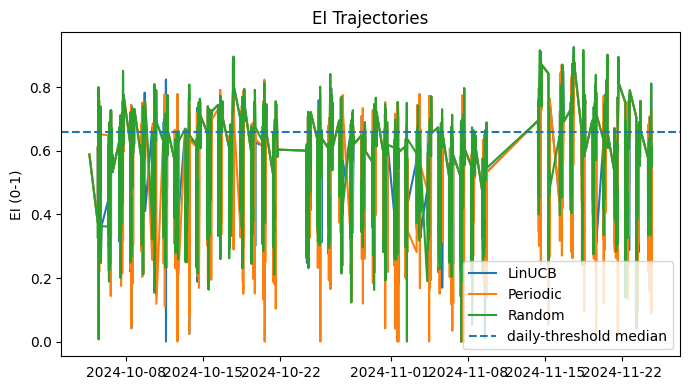

from matplotlib import pyplot as plt
summary['ERT(min)'].plot(kind='hist', bins=20, title='ERT(min)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['ACI'].plot(kind='hist', bins=20, title='ACI')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['budget_used(min)'].plot(kind='hist', bins=20, title='budget_used(min)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['eff(reward/min)'].plot(kind='hist', bins=20, title='eff(reward/min)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
summary.groupby('policy').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='ERT(min)', y='ACI', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='ACI', y='budget_used(min)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='budget_used(min)', y='eff(reward/min)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['budget_used(min)']
  ys = series['ERT(min)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('budget_used(min)', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('policy')):
  _plot_series(series, series_name, i)
  fig.legend(title='policy', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('budget_used(min)')
_ = plt.ylabel('ERT(min)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['budget_used(min)']
  ys = series['ACI']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('budget_used(min)', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('policy')):
  _plot_series(series, series_name, i)
  fig.legend(title='policy', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('budget_used(min)')
_ = plt.ylabel('ACI')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['budget_used(min)']
  ys = series['eff(reward/min)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('budget_used(min)', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('policy')):
  _plot_series(series, series_name, i)
  fig.legend(title='policy', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('budget_used(min)')
_ = plt.ylabel('eff(reward/min)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['budget_used(min)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'budget_used(min)'}, axis=1)
              .sort_values('budget_used(min)', ascending=True))
  xs = counted['budget_used(min)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('budget_used(min)', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('policy')):
  _plot_series(series, series_name, i)
  fig.legend(title='policy', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('budget_used(min)')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
summary['ERT(min)'].plot(kind='line', figsize=(8, 4), title='ERT(min)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['ACI'].plot(kind='line', figsize=(8, 4), title='ACI')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['budget_used(min)'].plot(kind='line', figsize=(8, 4), title='budget_used(min)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['eff(reward/min)'].plot(kind='line', figsize=(8, 4), title='eff(reward/min)')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['policy'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='ERT(min)', y='policy', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['policy'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='ACI', y='policy', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['policy'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='budget_used(min)', y='policy', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['policy'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='eff(reward/min)', y='policy', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# =========================
# 5) 실행 & 요약
# =========================
ei_lin, log_lin = sim("linucb",   alpha=alpha, seed=1)
ei_per, log_per = sim("periodic", seed=1)
ei_rnd, log_rnd = sim("random",   seed=1)

name_lin, day_lin, avg_lin = summarize_by_day("LinUCB",  ei_lin, log_lin)
name_per, day_per, avg_per = summarize_by_day("Periodic",ei_per, log_per)
name_rnd, day_rnd, avg_rnd = summarize_by_day("Random",  ei_rnd, log_rnd)

summary = pd.DataFrame([
    {"policy":name_lin, **avg_lin},
    {"policy":name_per, **avg_per},
    {"policy":name_rnd, **avg_rnd},
])
display(summary)
print("\nAction counts (LinUCB):\n", log_lin["action"].value_counts())

# 저장
outdir = "/content/work"
day_lin.to_csv(f"{outdir}/day_linucb.csv", index=False)
day_per.to_csv(f"{outdir}/day_periodic.csv", index=False)
day_rnd.to_csv(f"{outdir}/day_random.csv", index=False)
log_lin.to_csv(f"{outdir}/log_linucb.csv", index=False)
log_per.to_csv(f"{outdir}/log_periodic.csv", index=False)
log_rnd.to_csv(f"{outdir}/log_random.csv", index=False)
summary.to_csv(f"{outdir}/policy_summary_overall.csv", index=False)
print(f"Saved day_*.csv, log_*.csv, policy_summary_overall.csv in {outdir}")

# 궤적 확인(선택)
plt.figure(figsize=(7,4))
plt.plot(f["Time"], ei_lin, label="LinUCB")
plt.plot(f["Time"], ei_per, label="Periodic")
plt.plot(f["Time"], ei_rnd, label="Random")
plt.axhline(np.median(list(thr_by_date.values())), linestyle="--", label="daily-threshold median")
plt.ylabel("EI (0-1)"); plt.title("EI Trajectories"); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
# ============ Step 6. 개선율(%) + 95% CI ============

# 보상 r = 1.0*risk_gain + 0.7*prevent_gain + 1.0*cross_bonus - 0.5*minutes(a)
# [R1] 근접효과 관점(당장/차기 창의 위험 감소)을 반영.
# [R6] 위험 체류시간/면적(ERT/ACI) 축소와 정렬.

import numpy as np, pandas as pd

def pct_improve_lower_better(lin, base):
    den = np.where(base==0, np.nan, base)
    return 100.0*(base - lin)/den

def pct_improve_higher_better(lin, base):
    den = np.where(np.abs(base)<1e-12, np.nan, np.abs(base))
    return 100.0*(lin - base)/den

def boot_ci(x, it=2000, alpha=0.05, seed=0):
    x = np.asarray(x, float); x = x[np.isfinite(x)]
    rng = np.random.default_rng(seed)
    boots = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(it)]
    lo, hi = np.percentile(boots, [100*alpha/2, 100*(1-alpha/2)])
    return float(np.nanmean(x)), float(lo), float(hi)

def compare_vs_base(day_lin, day_base, base_name):
    m = day_lin.merge(day_base, on="date", suffixes=("_lin","_base")).dropna()
    ert = pct_improve_lower_better(m["ERT(min)_lin"], m["ERT(min)_base"])
    aci = pct_improve_lower_better(m["ACI_lin"],      m["ACI_base"])
    eff = pct_improve_higher_better(m["eff(reward/min)_lin"], m["eff(reward/min)_base"])
    row = pd.DataFrame([{
        "baseline": base_name,
        "ERT 개선(%)": round(boot_ci(ert)[0],1), "ERT 95%CI": tuple(round(x,1) for x in boot_ci(ert)[1:]),
        "ACI 개선(%)": round(boot_ci(aci)[0],1), "ACI 95%CI": tuple(round(x,1) for x in boot_ci(aci)[1:]),
        "효율 개선(%)": round(boot_ci(eff)[0],1), "효율 95%CI": tuple(round(x,1) for x in boot_ci(eff)[1:]),
        "일수(n)": len(m)
    }])
    return row

improve_tbl = pd.concat([
    compare_vs_base(day_lin, day_per, "Periodic"),
    compare_vs_base(day_lin, day_rnd, "Random")
], ignore_index=True)

display(improve_tbl)
improve_tbl.to_csv("/content/work/linucb_vs_baselines_improvements.csv", index=False)
print("Saved → /content/work/linucb_vs_baselines_improvements.csv")


,baseline,ERT 개선(%),ERT 95%CI,ACI 개선(%),ACI 95%CI,효율 개선(%),효율 95%CI,일수(n)
0,Periodic,-24.3,"(-41.3, -10.0)",-3.7,"(-15.6, 6.3)",-16.7,"(-22.2, -11.2)",46
1,Random,24.4,"(15.9, 32.5)",7.2,"(-7.9, 19.8)",11.1,"(6.2, 16.6)",46


Saved → /content/work/linucb_vs_baselines_improvements.csv


References (R):

[R1] Micro-randomized trials (MRT) for JITAI design.
     https://pmc.ncbi.nlm.nih.gov/articles/PMC4732571/
     → ‘결정시점’마다 근접효과를 추정/최적화하는 실험 설계. 본 코드의 10분 단위 의사결정 프레임, 근접지표 기반 보상 설계에 반영.

[R2] Contextual bandits in mobile health (review/tutorial).
     https://www.ambujtewari.com/research/tewari17ads.pdf
     → 컨텍스트 기반 온라인 개입 최적화 프레임. 본 코드의 선형 컨텍스추얼 밴딧(LinUCB) 가정/업데이트, 오프라인 로그(propensity) 기록 근거.

[R3] Contextual bandits – overview (nutshell).
     https://arxiv.org/pdf/1706.09090
     → 컨텍스추얼 밴딧 전반(선형 보상 가정, 탐험-활용). LinUCB 선택 규칙(UCB) 설명과 연결.

[R4] Robust actor–critic contextual bandit (capped-ℓ2).
     https://dl.acm.org/doi/pdf/10.1145/3233547.3233554
     → 센서/자가보고 이상치에 강건한 학습. 본 코드의 robust z-score/분위수 클리핑 아이디어의 배경(완전 동일 알고리즘은 아님).

[R5] Budget-aware multi(0/1/多)–selection bandits (LP-UCB/Greedy-UCB).
     https://arxiv.org/pdf/2202.03704
     → 시간·예산 동시 고려 프레임. 본 코드의 일일 예산, 예산가드(≤3분), 쿨다운 등 ‘가벼운’ 예산 제약 구현의 이론적 배경.

[R6] Rest and time-to-injury epidemiology (dose–response).
     https://pubmed.ncbi.nlm.nih.gov/22430076/
     → 휴식이 위험체류 시간을 지연시킨다는 근거. 본 코드의 ERT/ACI(임계 위 체류시간·면적) 최소화 목적과 연결.

[R7] LLM × contextual bandit for personalized messaging (recent).
     https://arxiv.org/html/2506.07275v2
     → (향후) 개입 ‘유형’은 밴딧이, 문구/톤은 LLM이 개인화하는 프레임. 본 코드는 유형 선택까지만 구현.
"""